![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Model-Agnostic Interpretation with Permutation Feature Importance

In this Notebook, we will demonstrate how to use the Permutation Feature Importance method and interpret its results.

--------


## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/ECCB-2024/2-Tutorial_PermutationFeatureImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [ ]:
# Mount drive folder to dbe abale to download repo
from google.colab import drive
drive.mount('/content/drive')

# Switch to correct folder'
%cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
# %rm -r XAI-Tutorials
# !git clone --branch ECCB-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials

# Install additional packages and fix package versions
%pip install fgclustering==1.1.0
%pip install ipython==8.4.0
%pip install jupyter==1.0.0
%pip install jupyterlab==4.0.5
%pip install matplotlib==3.5.3
%pip install notebook==7.0.3
%pip install numpy==1.23.2
%pip install pandas==2.2.2
%pip install scikit-learn==1.5.1
%pip install seaborn==0.13.2
%pip install shap==0.46.0
%pip install ucimlrepo==0.0.7

### Imports

Let's start with importing all required Python packages.

In [1]:
import utils
import pickle

import numpy as np

from sklearn.metrics import get_scorer, balanced_accuracy_score
from sklearn.inspection import permutation_importance

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The Wisconsin Breast Cancer Dataset

In this notebook, we will work with the **Wisconsin Breast Cancer dataset**, containing 569 samples of 212 malignant and 357 benign tumors. Tumors are described by 30 numeric features computed from a digitized image taken of breast mass (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)).

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_breastcancer.png?raw=true" width="700" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/code/midouazerty/breast-cancer-prediction-99)

In the notebook [*1-Tutorial_RandomForest_Models.ipynb*](./1-Tutorial_RandomForest_Models.ipynb), we explain how to do the exploratory data analysis, preprocess the data and train a Random Forest model with the given data. The focus of this notebook is the interpretation of the previously trained model.

In [3]:
# Load and unpack the data
with open('./models/model_rf_breastcancer.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
model_breastcancer = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, model_breastcancer.predict(X_train))*100,2)} % balanced accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, model_breastcancer.predict(X_test))*100,2)} % balanced accuracy.')

Model Performance on training data: 100.0 % balanced accuracy.
Model Performance on test data: 94.05 % balanced accuracy.


As we can see by the numbers above, our model performs well on the training set and also generalizes well to the independent test set.

**You should keep in mind that interpreting a low-performing model can lead to wrong conclusions.**

--------

## Now, what does my model actually think is important in the data?

### Permutation Feature Importance

**We prepared a small [Introduction to Permutation Feature Importance](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/pfi.html) for you, to help you understand how this method works.**

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/pfi.html#references).*

<font color='green'>

#### Question 1: What is achieved by permuting feature values?

<font color='grey'>

#### Your Answer: 

The existing relation between target and the feature are destroyed by randomly assigning new values to the given labels, making it impossible for the model to draw any conclusion from this feature to predict the label.

<font color='green'>

#### Question 2: Would it also be a good idea to permute the target instead of the features?

<font color='grey'>

#### Your Answer: 

No, since we could not measure an effect for each feature anymore.

<font color='green'>

#### Question 3: Why don't we leave out a feature instead of permuting it to measure its importance?

<font color='grey'>

#### Your Answer: 

Leaving out the feature would require training a second model with less input features, which then would make the comparison harder.

Now, let's use Permutation Feature Importance to get insights into the Random Forest Classification model we loaded above. We can use the scikit-learn implementation called `permutation_importance` to get the importance values for the features in our model. For measuring the performance drop when permuting a feature, we use the standard metric of our trained model, which is, in our case, the accuracy score. Using the same score enables us to evaluate the performance drop in relation to the baseline performance. We do 40 repetitions of permutation for each feature to get more reliable results.

*Note: this method is a **global** method, which means that it only provides explanations for the full dataset but not for individual examples.*

*Note: Features that are deemed of low importance for a bad model (low test score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.*

In [4]:
scorer = get_scorer("accuracy")

In [5]:
explanation_train = permutation_importance(
    model_breastcancer,
    X=X_train,
    y=y_train,
    n_repeats=40,
    random_state=seed,
    scoring=scorer
)

explanation_train["feature"] = X_train.columns

We will now plot bar histograms for visualizing the importance of each feature as obtained by the mean over the 40 repetitions.

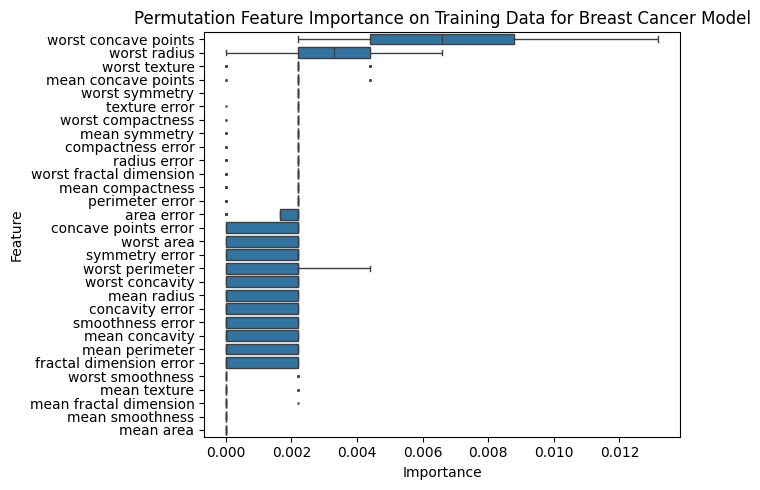

In [6]:
utils.plot_permutation_feature_importance(explanation_train, X_train, 'Permutation Feature Importance on Training Data for Breast Cancer Model')

<font color='green'>

#### Question 4: How should the feature importances be interpreted and what do the variance bars indicate?

<font color='grey'>

#### Your Answer: 

The feature importance is the (average over multiple permutations) decrease of a performance measure - in our case accuracy - compared to a model that did not have the feature permuted. The variance bars indicate the stability of the computed feature importance across multiple permutations.

Features with the largest importance score are the ones whose score is most decreased when the feature is permuted, indicating high relevance for the prediction of the target. For our Breast Cancer model, the *worst concave points* feature seems to have the highest impact on the model performance. Permuting this feature leads to a decrease in accuracy of ~ 0.7%. When comparing it to the baseline accuracy of 100%, we notice that permuting the *worst concave points* feature has almost no effect on the model accuracy. The plot above suggest that none of the features are important, which however is in contradiction with the high training accuracy computed as baseline: some feature must be important.

<font color='green'>

#### Question 5: Why are none of the features considered important?

<font color='grey'>

#### Your Answer: 

As mentioned before, permutation feature importance assumes feature independence. High correlation among features breaks this assumption and hence, can have an impact on the feature importance analysis.

---

### Dealing with Correlated Features

In the introduction video you already learned that applying permutation importance to datasets that contain correlated features can be problematic in various ways.
This is also emphasized in the [scikit_learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance):

"*When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.*"

So, let's have a look of the amount of correlation we exhibit in our dataset.

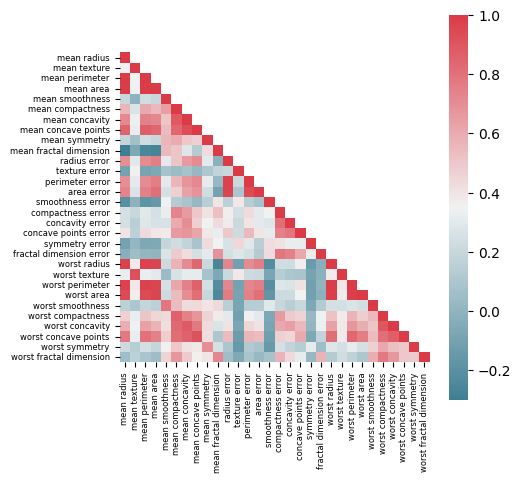

In [7]:
utils.plot_correlation_matrix(X_train, figsize=(5,5), annot=False, labelsize=6)

Looking at the correlation matrix above, we notice that we have a lot of correlation among features in our dataset. For instance, the *worst concave points* is highly correlated (correlation > 0.8) to eight other features in the dataset.  

To showcase the effect of correlation on the feature importance analysis, we will load a second Random Forest model that was trained on selected set of uncorrelated features. 

In [8]:
# Load and unpack the data
with open('./models/model_rf_breastcancer_sel.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train_sel = data_and_model[0]
X_test_sel = data_and_model[1]
y_train_sel = data_and_model[2]
y_test_sel = data_and_model[3]
model_breastcancer_sel = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train_sel, model_breastcancer_sel.predict(X_train_sel))*100,2)} % balanced accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test_sel, model_breastcancer_sel.predict(X_test_sel))*100,2)} % balanced accuracy.')

Model Performance on training data: 98.36 % balanced accuracy.
Model Performance on test data: 89.38 % balanced accuracy.


Next, we compute the permutation feature importance for the Random Forest Classifier trained on the selected feature set.

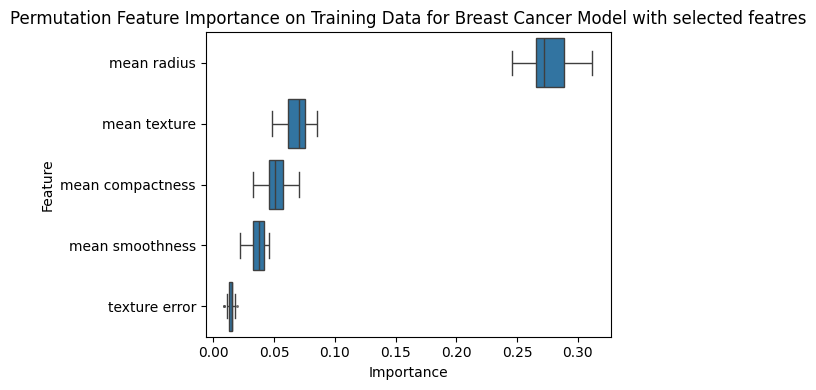

In [9]:
explanation_train_sel = permutation_importance(
    model_breastcancer_sel,
    X=X_train_sel,
    y=y_train_sel,
    n_repeats=40,
    random_state=seed,
    scoring=scorer
)

explanation_train_sel["feature"] = X_train_sel.columns

utils.plot_permutation_feature_importance(explanation_train_sel, X_train_sel, 'Permutation Feature Importance on Training Data for Breast Cancer Model with selected featres', figsize=(6,4))

The plots above show how much influence feature correlation has on the permutation feature importances. For the model trained on the selected feature set, the most important feature leads to a mean decrease in accuracy of ~30%, which is in concordance with the observed model accuracy. In addition, the feature importance has a much higher stability as the variance of the feature importances across different permutations is much smaller. This illustrates why you have to be careful when using Permutation Feature Importance for models that were trained on datasets with high feature correlations!

We are not restricted to obtaining feature importances of the same data set we used to train the model. Instead, we could use the same approach to identify the most important features in the test set.

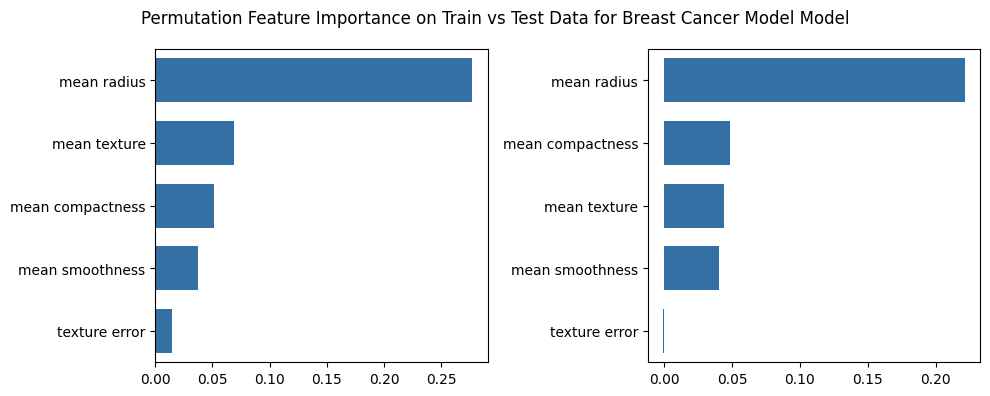

In [10]:
explanation_test_sel = permutation_importance(
    model_breastcancer_sel,
    X=X_test_sel,
    y=y_test_sel,
    n_repeats=40,
    random_state=seed,
    scoring=scorer)

explanation_test_sel["feature"] = X_test_sel.columns

utils.plot_permutation_feature_importance_train_vs_test(explanation_train_sel, X_train_sel, explanation_test_sel, X_test_sel, 'Permutation Feature Importance on Train vs Test Data for Breast Cancer Model Model')

It seems that for both datasets, largely the same features are identified as important, which is reassuring.

*Note: this agreement of important features between training and testing datasets is not guaranteed. In such cases, it is not straightforward to decide on the "truly important" features for the model. A disagreement can be caused by high correlations in the dataset or even be an indicator that the model is not generalizeable.*